# Udacity Capstone Project - Artwork Classifier


Author: Shawn Gong


## Part I: Introduction





## Part II: Getting Data

### Loading the libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import traintestsplit
from tqdm import tqdm, tqdm_notebook
import random
import PIL
from sklearn.datasets import load_files
from sklearn.metrics import *
from keras.utils import np_utils,plot_model
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import optimizers
import shutil
import squarify
import pydot

In [36]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to had
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

tqdm==4.40.2
squarify==0.4.3
six==1.13.0
seaborn==0.9.0
scikit-learn==0.22
requests==2.22.0
pydot==1.4.1
Pillow==7.0.0
pandas==0.25.3
numpy==1.17.4
matplotlib==3.1.1


#### Reading Data

In [4]:
# Extracting the files
shutil.unpack_archive('best-artworks-of-all-time.zip')

In [5]:
# Check the working directory
print(os.listdir())

['.idea', '.ipynb_checkpoints', 'artists.csv', 'best-artworks-of-all-time.zip', 'images', 'resized', 'saved_models1', 'traintestsplit.py', 'Udacity_Capstone_Project.ipynb', 'Unconfirmed 884084.crdownload', 'Untitled.ipynb', '__pycache__']


In [6]:
print(os.listdir("images/images"))

['Albrecht_DuΓòá├¬rer', 'Albrecht_Du╠êrer', 'Alfred_Sisley', 'Amedeo_Modigliani', 'Andrei_Rublev', 'Andy_Warhol', 'Camille_Pissarro', 'Caravaggio', 'Claude_Monet', 'Diego_Rivera', 'Diego_Velazquez', 'Edgar_Degas', 'Edouard_Manet', 'Edvard_Munch', 'El_Greco', 'Eugene_Delacroix', 'Francisco_Goya', 'Frida_Kahlo', 'Georges_Seurat', 'Giotto_di_Bondone', 'Gustave_Courbet', 'Gustav_Klimt', 'Henri_de_Toulouse-Lautrec', 'Henri_Matisse', 'Henri_Rousseau', 'Hieronymus_Bosch', 'Jackson_Pollock', 'Jan_van_Eyck', 'Joan_Miro', 'Kazimir_Malevich', 'Leonardo_da_Vinci', 'Marc_Chagall', 'Michelangelo', 'Mikhail_Vrubel', 'Pablo_Picasso', 'Paul_Cezanne', 'Paul_Gauguin', 'Paul_Klee', 'Peter_Paul_Rubens', 'Pierre-Auguste_Renoir', 'Pieter_Bruegel', 'Piet_Mondrian', 'Raphael', 'Rembrandt', 'Rene_Magritte', 'Salvador_Dali', 'Sandro_Botticelli', 'Titian', 'Vasiliy_Kandinskiy', 'Vincent_van_Gogh', 'William_Turner']


We can see that there are some mojibake in two of the folders. This issue exists in the original zip file as well. This is probably due to the encoding error of German character. To find the correct labels for these folders, we can refer to the attached csv file that comes with the image data. 

In [2]:
artists = pd.read_csv("artists.csv")

In [3]:
artists.shape

(50, 8)

## Part III: Exploring the Dataset

In [4]:
artists.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [5]:
artists.name

0             Amedeo Modigliani
1            Vasiliy Kandinskiy
2                  Diego Rivera
3                  Claude Monet
4                 Rene Magritte
5                 Salvador Dali
6                 Edouard Manet
7                 Andrei Rublev
8              Vincent van Gogh
9                  Gustav Klimt
10             Hieronymus Bosch
11             Kazimir Malevich
12               Mikhail Vrubel
13                Pablo Picasso
14            Peter Paul Rubens
15        Pierre-Auguste Renoir
16               Francisco Goya
17                  Frida Kahlo
18                     El Greco
19               Albrecht Dürer
20                Alfred Sisley
21               Pieter Bruegel
22                 Marc Chagall
23            Giotto di Bondone
24            Sandro Botticelli
25                   Caravaggio
26            Leonardo da Vinci
27              Diego Velazquez
28                Henri Matisse
29                 Jan van Eyck
30                  Edgar Degas
31      

In [6]:
artists_sorted = artists.sort_values(by = ['paintings'], ascending=False)

Since the class is highly imbalanced, a class weight asscociated with each artist is required. Through assigning a class weight, the algorithm will penalize the misclassification of classes with fewer observations more than those with more observations. I will also only take a subset of the artists, as a number of artists does not have a lot of works in their portfolio. Including these artists in the model could negatively impact the performance of the model.

In [7]:
artists_subset = artists_sorted[artists_sorted['paintings'] >= 150].reset_index()

artists_subset['class_weight'] = max(artists_subset['paintings']) / (artists_subset.shape[0] * np.sqrt(artists_subset['paintings']))

artists_names = artists_subset['name'].str.replace(" ", "_").values

In [8]:
class_weight = artists_subset['class_weight'].to_dict()
class_weight
number_classes = artists_subset.shape[0]

#### Explore Images

In [14]:
# Getting the directory for all images
images_dir = "images/images"
artists_dir = os.listdir(images_dir)


# See if all directories exist
for name in artists_names:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> images/images\Vincent_van_Gogh
Found --> images/images\Edgar_Degas
Found --> images/images\Pablo_Picasso
Found --> images/images\Pierre-Auguste_Renoir
Did not find --> images/images\Albrecht_Dürer
Found --> images/images\Paul_Gauguin
Found --> images/images\Francisco_Goya
Found --> images/images\Rembrandt
Found --> images/images\Alfred_Sisley
Found --> images/images\Titian
Found --> images/images\Marc_Chagall
Found --> images/images\Rene_Magritte
Found --> images/images\Amedeo_Modigliani
Found --> images/images\Paul_Klee
Found --> images/images\Henri_Matisse
Found --> images/images\Andy_Warhol
Found --> images/images\Mikhail_Vrubel
Found --> images/images\Sandro_Botticelli


The Albrecht_Dürer one has encoding issues in the system directory, renaming it manually.

In [15]:
os.listdir("images/images")

['Albrecht_DuΓòá├¬rer',
 'Albrecht_Du╠êrer',
 'Alfred_Sisley',
 'Amedeo_Modigliani',
 'Andrei_Rublev',
 'Andy_Warhol',
 'Camille_Pissarro',
 'Caravaggio',
 'Claude_Monet',
 'Diego_Rivera',
 'Diego_Velazquez',
 'Edgar_Degas',
 'Edouard_Manet',
 'Edvard_Munch',
 'El_Greco',
 'Eugene_Delacroix',
 'Francisco_Goya',
 'Frida_Kahlo',
 'Georges_Seurat',
 'Giotto_di_Bondone',
 'Gustave_Courbet',
 'Gustav_Klimt',
 'Henri_de_Toulouse-Lautrec',
 'Henri_Matisse',
 'Henri_Rousseau',
 'Hieronymus_Bosch',
 'Jackson_Pollock',
 'Jan_van_Eyck',
 'Joan_Miro',
 'Kazimir_Malevich',
 'Leonardo_da_Vinci',
 'Marc_Chagall',
 'Michelangelo',
 'Mikhail_Vrubel',
 'Pablo_Picasso',
 'Paul_Cezanne',
 'Paul_Gauguin',
 'Paul_Klee',
 'Peter_Paul_Rubens',
 'Pierre-Auguste_Renoir',
 'Pieter_Bruegel',
 'Piet_Mondrian',
 'Raphael',
 'Rembrandt',
 'Rene_Magritte',
 'Salvador_Dali',
 'Sandro_Botticelli',
 'Titian',
 'Vasiliy_Kandinskiy',
 'Vincent_van_Gogh',
 'William_Turner']

In [16]:
os.rename('images/images/Albrecht_DuΓòá├¬rer','images/images/Albrecht_Dürer')

In [17]:
# There is a duplicated directory when extracting Albrecht_Dürer, remove it
shutil.rmtree('images/images/Albrecht_Du╠êrer')

In [18]:
traintestsplit.main("images/images", "images/train", train_ratio = 0.2)

In [19]:
os.rename('images/images','images/test')

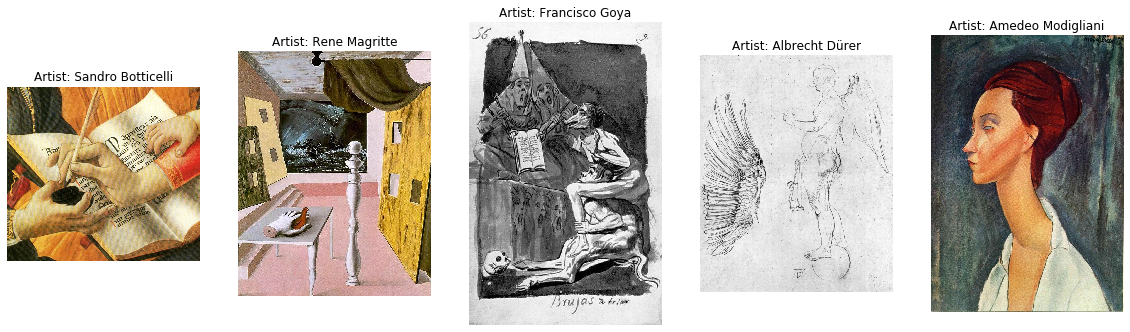

In [9]:
# Randomly print 
images_dir_train = "images/train"
images_dir_test = "images/test"
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,20))

for i in range(n):
    random_artist = random.choice(artists_names)
    random_image = random.choice(os.listdir(os.path.join(images_dir_train, random_artist)))
    random_image_file = os.path.join(images_dir_train, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')
    
plt.show()

#### Exploratory Data Analysis

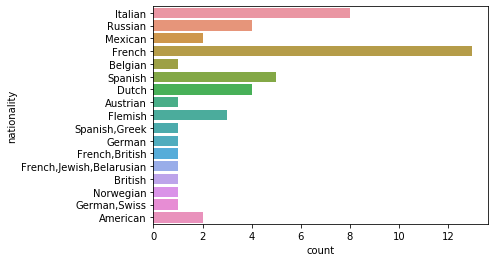

In [10]:
# How many artists in each country
sns.countplot(y = 'nationality', data= artists)

Text(0.5, 1.0, 'The top 10 artists who painted the most paintings')

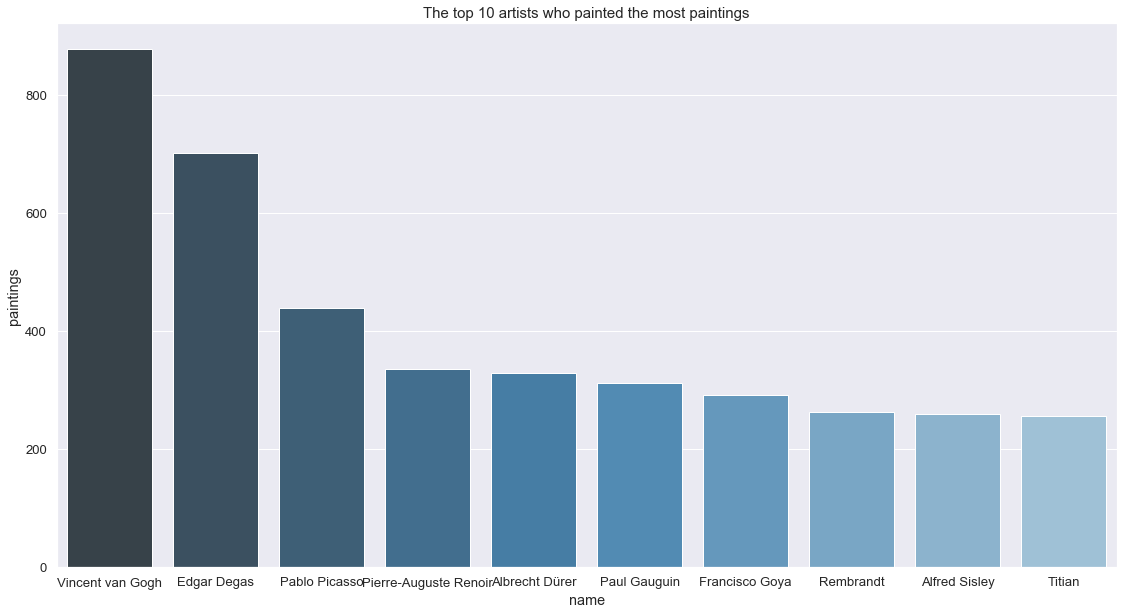

In [39]:
# The first 10 artists sorted by number of paintings
plt.subplots(figsize = (19, 10))
sns.set(style = 'darkgrid', font_scale=1.1)
sns.barplot(y = 'paintings', x = 'name', data = artists.sort_values(by = 'paintings', ascending = False).head(10),
           palette="Blues_d",
           ).set_title("The top 10 artists who painted the most paintings", size = 15)

Text(0.5, 1.0, 'The top 10 artists who painted the least paintings')

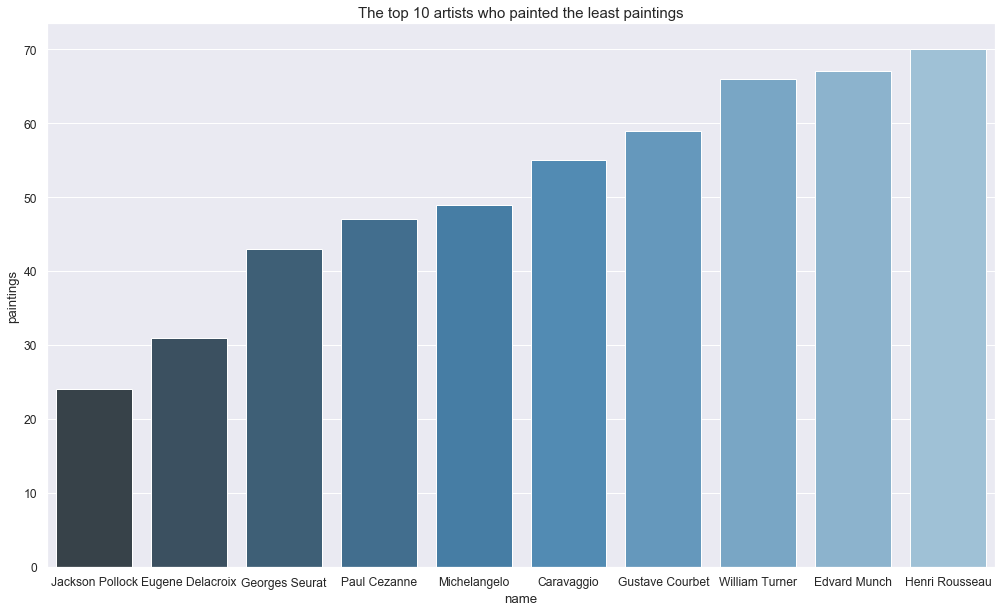

In [12]:
# The 10 artists who painted the least paintings
plt.subplots(figsize = (17, 10))
sns.set(style = 'darkgrid', font_scale=1.2)
sns.barplot(y = 'paintings', x = 'name', data = artists.sort_values(by = 'paintings', ascending = True).head(10),
           palette="Blues_d",
           ).set_title("The top 10 artists who painted the least paintings", size = 15)

In [13]:
# How many artists are there in each genre
artist_genre = artists.groupby(['genre']).sum().drop(['id'], axis = 1).reset_index()
artist_genre

,genre,paintings
0,Abstract Expressionism,24
1,Baroque,586
2,Byzantine Art,99
3,Cubism,439
4,Early Renaissance,164
5,Expressionism,193
6,"Expressionism,Abstractionism",88
7,"Expressionism,Abstractionism,Surrealism",188
8,High Renaissance,301
9,"High Renaissance,Mannerism",255


In [14]:
artist_genre.columns

Index(['genre', 'paintings'], dtype='object')

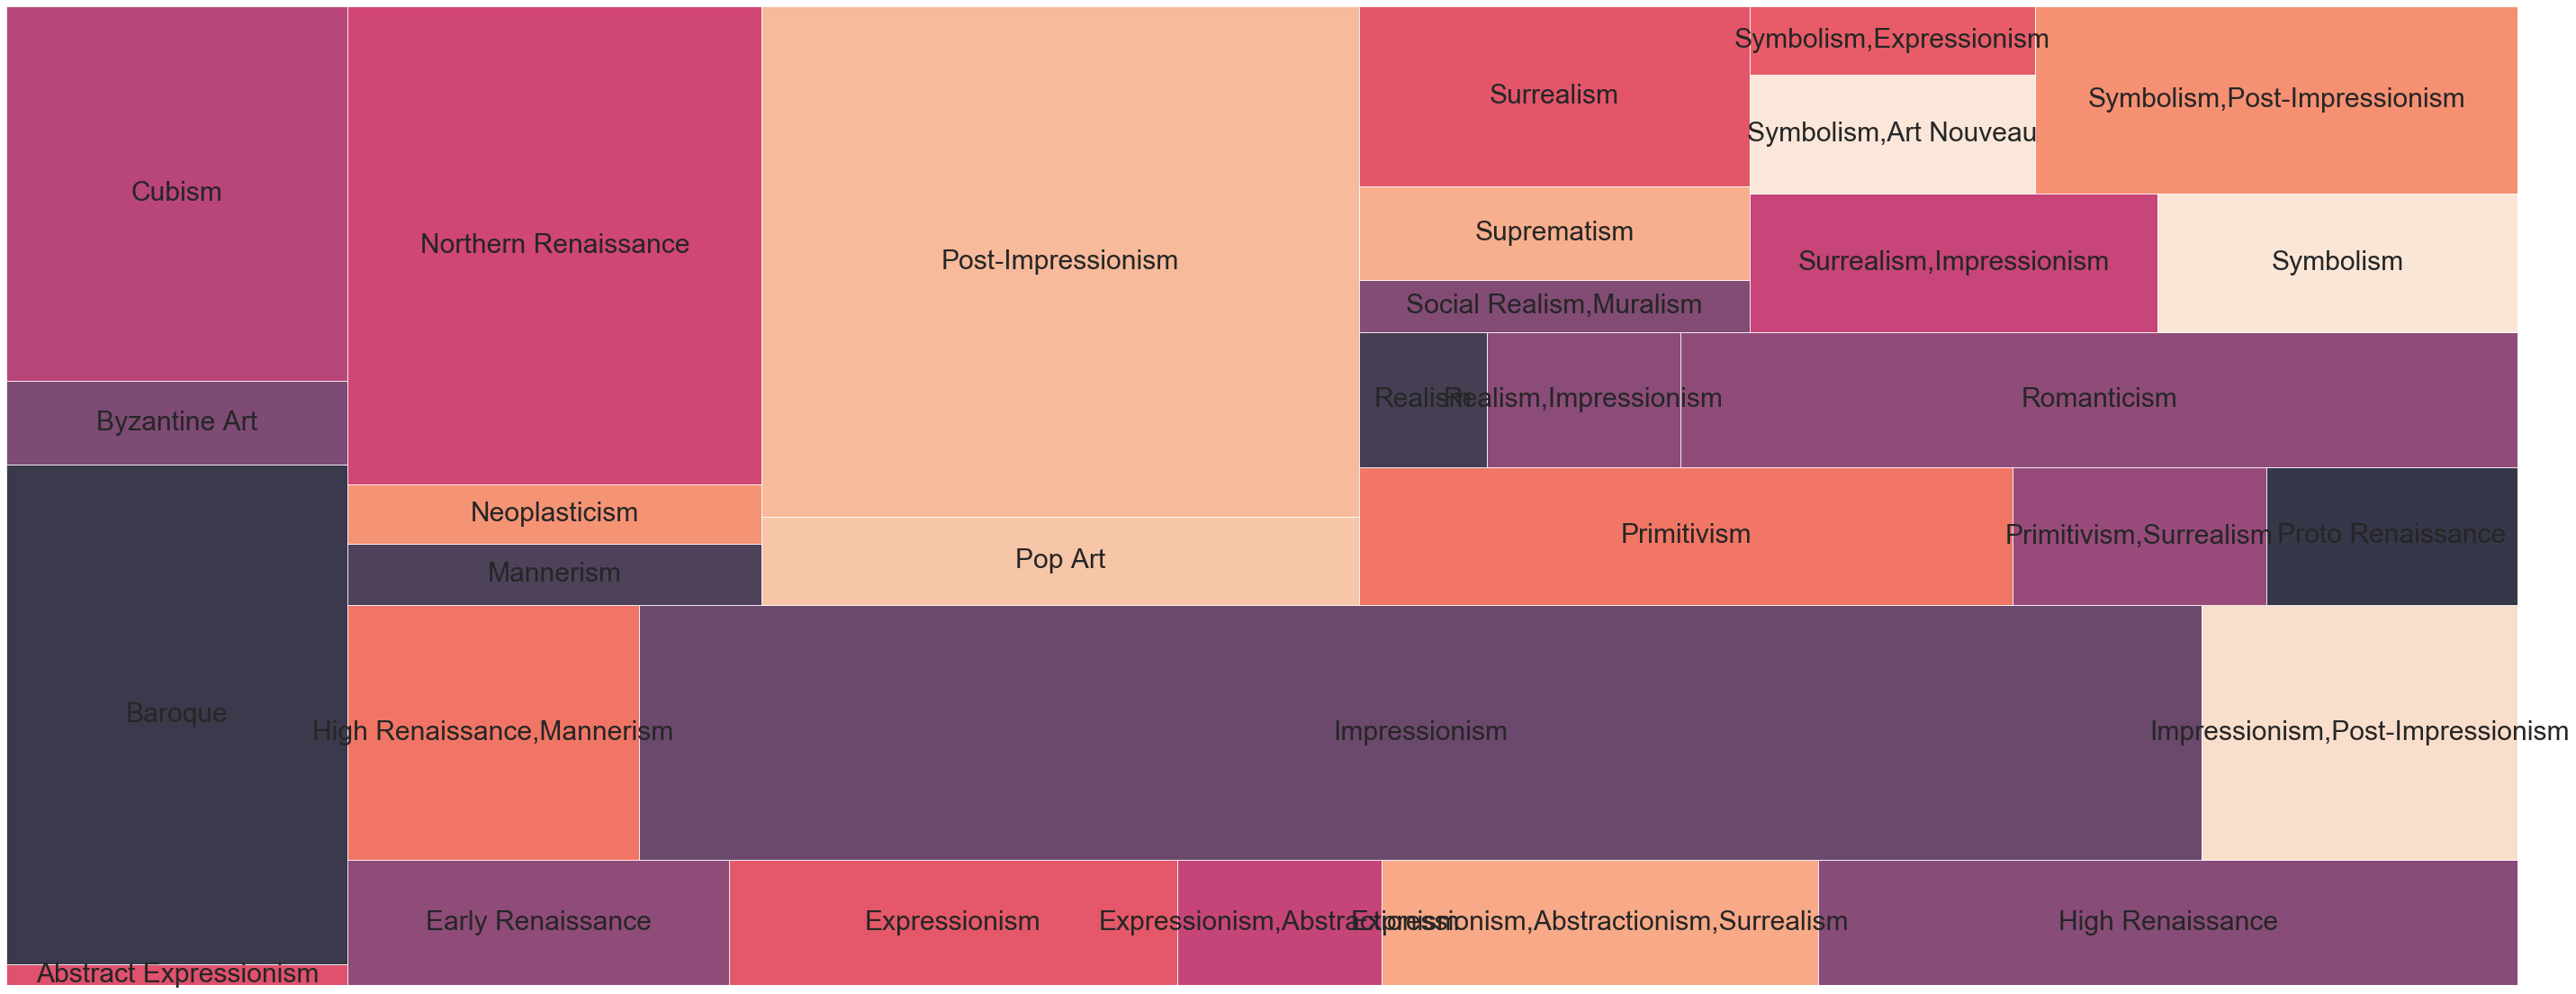

In [15]:
plt.subplots(figsize = (50, 20))
squarify.plot(sizes=artist_genre['paintings'],label = artist_genre['genre'], alpha=.8, text_kwargs={'fontsize':30})
plt.axis('off')
plt.show()

## Part IV: Model Building

### Image Augmentation

In [16]:
# Augment data
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_subset.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.25,
                                   rescale=1./255.,
                                   #rotation_range=30,
                                   #width_shift_range=0.05,
                                   #height_shift_range=0.05,
                                   shear_range=5,
                                   zoom_range=[1.0, 1.4],
                                   #brightness_range = [0.9, 1.0],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory=images_dir_train,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_names.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir_train,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_names.tolist()
                                                   )
test_generator = test_datagen.flow_from_directory(directory=images_dir_test,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    classes=artists_names.tolist())

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID, "and", STEP_SIZE_TEST)

Found 3354 images belonging to 18 classes.
Found 1107 images belonging to 18 classes.
Found 1115 images belonging to 18 classes.
Total number of batches = 209 and 69 and 69


#### Plot the Original and Augmented Image

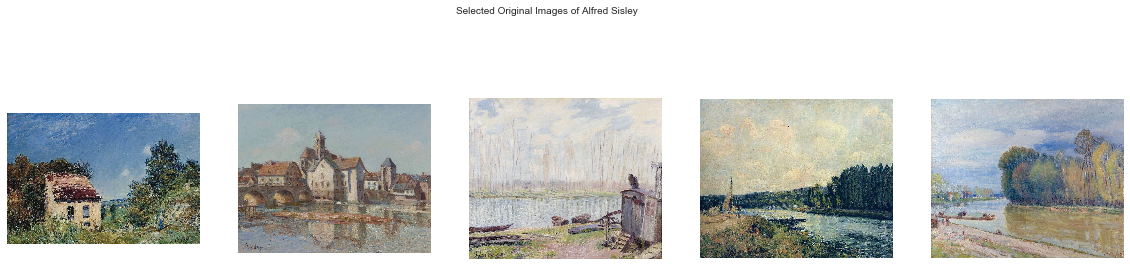

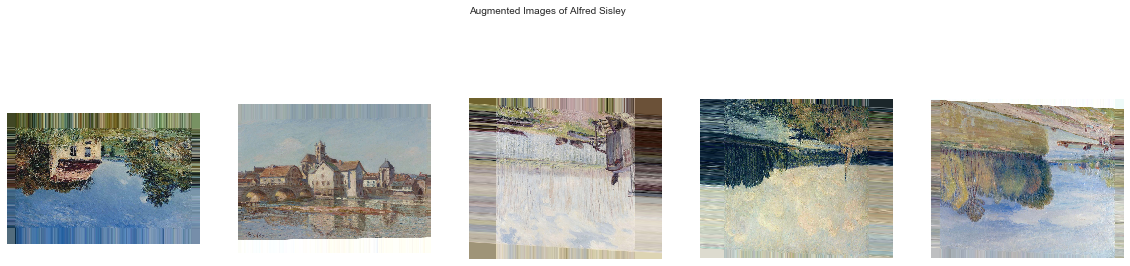

''

In [17]:
# Show the original and the augmented images
# Randomly select artists
random_artist = random.choice(artists_names)
random_image_list = []
for image in range(5):
  random_image = random.choice(os.listdir(os.path.join(images_dir_train, random_artist)))
  random_image_list.append(os.path.join(images_dir_train, random_artist, random_image))
# visualize subset of training data
fig, axes = plt.subplots(1, 5, figsize=(20,5))

for i in range(len(random_image_list)):
    image = plt.imread(random_image_list[i])
    axes[i].imshow(image)
    axes[i].axis('off')
fig.suptitle('Selected Original Images of ' + random_artist.replace('_', ' '), fontsize=10)
plt.show()
fig, axes = plt.subplots(1, 5, figsize=(20,5))
# visualize augmented images
for i in range(len(random_image_list)):
    aug_image = train_datagen.random_transform(plt.imread(random_image_list[i]))
    axes[i].imshow(aug_image)
    axes[i].axis('off')
fig.suptitle('Augmented Images of ' + random_artist.replace('_', ' '), fontsize=10)
plt.show()
;

### Building the Model

In [40]:
os.makedirs("saved_models")

In [18]:
from keras.callbacks import *

checkpointer_benchmark = ModelCheckpoint(filepath='saved_models/weights.best.benchmark.hdf5', 
                               verbose=1, save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [19]:
# Benchmark model: A Simple CNN network
benchmark_model = Sequential()

### TODO: Define your architecture.
benchmark_model.add(Conv2D(filters = 16, kernel_size = 3, padding = "valid", activation = "relu", input_shape = (224, 224, 3)))
benchmark_model.add(MaxPooling2D(pool_size = 2))
benchmark_model.add(Dropout(0.2))

benchmark_model.add(Conv2D(filters = 32, kernel_size = 3, padding = "valid", activation = "relu"))
benchmark_model.add(MaxPooling2D(pool_size = 2))
benchmark_model.add(Dropout(0.2))

benchmark_model.add(Conv2D(filters = 64, kernel_size = 3, padding = "valid", activation = "relu"))
benchmark_model.add(MaxPooling2D(pool_size = 2))
benchmark_model.add(Dropout(0.2))

benchmark_model.add(Conv2D(filters = 128, kernel_size = 3, padding = "valid", activation = "relu"))
benchmark_model.add(MaxPooling2D(pool_size = 2))
benchmark_model.add(Dropout(0.2))

benchmark_model.add(Conv2D(filters = 128, kernel_size = 3, padding = "valid", activation = "relu"))
benchmark_model.add(MaxPooling2D(pool_size = 2))
benchmark_model.add(Dropout(0.2))

benchmark_model.add(Conv2D(filters = 256, kernel_size = 3, padding = "valid", activation = "relu"))
benchmark_model.add(MaxPooling2D(pool_size = 2))
benchmark_model.add(Dropout(0.2))

benchmark_model.add(GlobalAveragePooling2D())
benchmark_model.add(Dense(512, activation = "relu"))
benchmark_model.add(Dense(n_classes, activation = "softmax"))

benchmark_model.compile(loss='categorical_crossentropy',
              optimizer= optimizers.rmsprop(lr = 1e-4),
              metrics=['accuracy'])
benchmark_model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 54, 54, 32)        0         
____________________

In [20]:
n_epoch = 20
CNN_benchmark = benchmark_model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, checkpointer_benchmark, early_stop],
                              use_multiprocessing=False,
                              workers=16,
                              class_weight=class_weight
                             )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





209/209 [==============================] - 30s 145ms/step - loss: 7.6485 - acc: 0.1483 - val_loss: 2.8379 - val_acc: 0.1739

Epoch 00001: val_loss improved from inf to 2.83791, saving model to saved_models/weights.best.benchmark.hdf5
Epoch 2/20
209/209 [==============================] - 23s 108ms/step - loss: 7.2491 - acc: 0.1786 - val_loss: 2.7256 - val_acc: 0.1595

Epoch 00002: val_loss improved from 2.83791 to 2.72557, saving model to saved_models/weights.best.benchmark.hdf5
Epoch 3/20
209/209 [==============================] - 23s 110ms/step - loss: 7.1117 - acc: 0.1853 - val_loss: 2.7343 - val_acc: 0.1494

Epoch 00003: val_loss did not improve from 2.72557
Epoch 4/20
209/209 [==============================] - 23s 111ms/step - loss: 7.0127 - acc: 0.2009 - val_loss: 2.6768 - val_acc: 0.1962

Epoch 00004: val_loss improved from 2.72557 to 2.67683, saving model to saved_mod

In [23]:
benchmark_model.load_weights('saved_models/weights.best.benchmark.hdf5')

In [36]:
# Evaluate on the test set
performance_benchmark = benchmark_model.evaluate_generator(generator = test_generator, steps=STEP_SIZE_TEST, verbose=1)
performance_labels_benchmark = benchmark_model.metrics_names
print("The {} of the test set:{}".format(performance_labels_benchmark[0], performance_benchmark[0]))
print("The {} of the test set:{}".format(performance_labels_benchmark[1], performance_benchmark[1]))

69/69 [==============================] - 17s 241ms/step
The loss of the test set:2.307160206463026
The acc of the test set:0.2708333333333333


#### Transfer Learning Using ResNet-50 Pretrained Weight

In [16]:
# Base-model ResNet 50
base_model = ResNet50(weights = "imagenet", include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True
output = base_model.output
output = Flatten()(output)
base_model = Model(base_model.input, output=output)

base_model.summary()


F:\Anaconda\envs\Udacity_Capstone\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

F:\Anaconda\envs\Udacity_Capstone\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  


In [17]:
model = Sequential()
model.add(base_model)
model.add(Dense(512, activation='relu', input_dim=train_input_shape, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(number_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer= optimizers.rmsprop(lr = 1e-4),
              metrics=['accuracy'])
model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 100352)            23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               51380736  
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                16416     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
________________________

In [18]:
# Train the model
checkpointer_resnet50 = ModelCheckpoint(filepath='saved_models/weights.best.resnet50.hdf5', 
                               verbose=1, save_best_only=True)
n_epoch = 100

CNN_1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, checkpointer_resnet50, early_stop],
                              use_multiprocessing=False,
                              workers=16,
                              class_weight=class_weight
                             )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
209/209 [==============================] - 63s 301ms/step - loss: 5.8880 - acc: 0.3541 - val_loss: 1.8255 - val_acc: 0.4457

Epoch 00001: val_loss improved from inf to 1.82549, saving model to saved_models/weights.best.resnet50.hdf5
Epoch 2/100
209/209 [==============================] - 50s 239ms/step - loss: 4.1042 - acc: 0.5644 - val_loss: 1.3222 - val_acc: 0.6214

Epoch 00002: val_loss improved from 1.82549 to 1.32218, saving model to saved_models/weights.best.resnet50.hdf5
Epoch 3/100
209/209 [==============================] - 48s 231ms/step - loss: 3.3749 - acc: 0.6541 - val_loss: 1.4132 - val_acc: 0.6398

Epoch 00003: val_loss did not improve from 1.32218
Epoch 4/100
209/209 [==============================] - 49s 233ms/step - loss: 2.9694 - acc: 0.7046 - val_loss: 1.1153 - val_acc: 0.6856

Epoch 00004: val_loss improved from 1.32218 to 1.11526, saving model to saved_models/

In [19]:
# Load the model with best weight and test performance
model.load_weights('saved_models/weights.best.ResNet50.hdf5')

In [20]:
# Evaluate on the test set
performance_resnet50 = model.evaluate_generator(generator = test_generator, steps=STEP_SIZE_TEST, verbose=1)
performance_labels_resnet50 = model.metrics_names
print("The {} of the test set:{}".format(performance_labels_resnet50[0], performance_resnet50[0]))
print("The {} of the test set:{}".format(performance_labels_resnet50[1], performance_resnet50[1]))

69/69 [==============================] - 18s 267ms/step
The loss of the test set:0.6877555017885955
The acc of the test set:0.8115942028985508


In [21]:
train_input_shape_Xception = (299, 299, 3)
n_classes = artists_subset.shape[0]

train_datagen_Xception = ImageDataGenerator(validation_split=0.25,
                                   rescale=1./255.,
                                   #rotation_range=30,
                                   #width_shift_range=0.05,
                                   #height_shift_range=0.05,
                                   shear_range=5,
                                   zoom_range=[1.0, 1.4],
                                   #brightness_range = [0.9, 1.0],
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )
test_datagen_Xception = ImageDataGenerator(rescale=1./255)

train_generator_Xception = train_datagen_Xception.flow_from_directory(directory=images_dir_train,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_names.tolist()
                                                   )

valid_generator_Xception = train_datagen_Xception.flow_from_directory(directory=images_dir_train,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_names.tolist()
                                                   )
test_generator_Xception = test_datagen_Xception.flow_from_directory(directory=images_dir_test,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    classes=artists_names.tolist())

STEP_SIZE_TRAIN_Xception = train_generator_Xception.n//train_generator_Xception.batch_size
STEP_SIZE_VALID_Xception = valid_generator_Xception.n//valid_generator_Xception.batch_size
STEP_SIZE_TEST_Xception = test_generator_Xception.n//test_generator_Xception.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN_Xception, "and", STEP_SIZE_VALID_Xception, "and", STEP_SIZE_TEST_Xception)

Found 3354 images belonging to 18 classes.
Found 1107 images belonging to 18 classes.
Found 1115 images belonging to 18 classes.
Total number of batches = 209 and 69 and 69


In [42]:
# Base-model Xception
base_model_Xception = Xception(weights = "imagenet", include_top=False, input_shape=train_input_shape)
for layer in base_model_Xception.layers:
    layer.trainable = True
output = base_model_Xception.output
output = Flatten()(output)
base_model_Xception = Model(base_model_Xception.input, output=output)
base_model_Xception.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_co

F:\Anaconda\envs\Udacity_Capstone\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  import sys


In [43]:
model_Xception = Sequential()
model_Xception.add(base_model_Xception)
model_Xception.add(Dense(512, activation='relu', input_dim=train_input_shape))
model_Xception.add(BatchNormalization())
model_Xception.add(Dropout(0.3))
model_Xception.add(Dense(32, activation='relu'))
model_Xception.add(BatchNormalization())
model_Xception.add(Dropout(0.3))
model_Xception.add(Dense(number_classes, activation='softmax'))
model_Xception.compile(loss='categorical_crossentropy',
              optimizer= optimizers.rmsprop(lr = 1e-4),
              metrics=['accuracy'])
model_Xception.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 100352)            20861480  
_________________________________________________________________
dense_3 (Dense)              (None, 512)               51380736  
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                16416     
_________________________________________________________________
batch_normalization_6 (Batch (None, 32)                128       
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
__________

In [24]:
# Train the model
n_epoch = 100
checkpointer_Xception = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)
CNN_Xception = model_Xception.fit_generator(generator=train_generator_Xception, steps_per_epoch=STEP_SIZE_TRAIN_Xception,
                              validation_data=valid_generator_Xception, validation_steps=STEP_SIZE_VALID_Xception,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, checkpointer_Xception, early_stop],
                              use_multiprocessing=False,
                              workers=16,
                              class_weight=class_weight
                             )

Epoch 1/100
209/209 [==============================] - 78s 374ms/step - loss: 6.4284 - acc: 0.2916 - val_loss: 1.9894 - val_acc: 0.4457

Epoch 00001: val_loss improved from inf to 1.98940, saving model to saved_models/weights.best.Xception.hdf5
Epoch 2/100
209/209 [==============================] - 70s 335ms/step - loss: 4.2945 - acc: 0.5280 - val_loss: 1.4708 - val_acc: 0.5747

Epoch 00002: val_loss improved from 1.98940 to 1.47082, saving model to saved_models/weights.best.Xception.hdf5
Epoch 3/100
209/209 [==============================] - 70s 335ms/step - loss: 3.4087 - acc: 0.6478 - val_loss: 1.2454 - val_acc: 0.6599

Epoch 00003: val_loss improved from 1.47082 to 1.24544, saving model to saved_models/weights.best.Xception.hdf5
Epoch 4/100
209/209 [==============================] - 71s 339ms/step - loss: 2.7770 - acc: 0.7276 - val_loss: 1.0255 - val_acc: 0.7149

Epoch 00004: val_loss improved from 1.24544 to 1.02550, saving model to saved_models/weights.best.Xception.hdf5
Epoch 5/

209/209 [==============================] - 72s 343ms/step - loss: 0.1910 - acc: 0.9897 - val_loss: 0.6206 - val_acc: 0.8405

Epoch 00038: val_loss did not improve from 0.57882
Epoch 39/100
209/209 [==============================] - 72s 344ms/step - loss: 0.1950 - acc: 0.9917 - val_loss: 0.6421 - val_acc: 0.8286

Epoch 00039: val_loss did not improve from 0.57882
Epoch 40/100
209/209 [==============================] - 73s 351ms/step - loss: 0.2133 - acc: 0.9877 - val_loss: 0.6390 - val_acc: 0.8423

Epoch 00040: val_loss did not improve from 0.57882
Epoch 41/100
209/209 [==============================] - 72s 345ms/step - loss: 0.2259 - acc: 0.9873 - val_loss: 0.5956 - val_acc: 0.8414

Epoch 00041: val_loss did not improve from 0.57882
Epoch 42/100
209/209 [==============================] - 73s 348ms/step - loss: 0.2101 - acc: 0.9898 - val_loss: 0.6764 - val_acc: 0.8258

Epoch 00042: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.

Epoch 00042: val_loss did not improve

209/209 [==============================] - 72s 342ms/step - loss: 0.2057 - acc: 0.9871 - val_loss: 0.6125 - val_acc: 0.8478

Epoch 00078: val_loss did not improve from 0.57781
Epoch 79/100
209/209 [==============================] - 71s 340ms/step - loss: 0.1992 - acc: 0.9883 - val_loss: 0.6509 - val_acc: 0.8286

Epoch 00079: val_loss did not improve from 0.57781
Epoch 80/100
209/209 [==============================] - 71s 340ms/step - loss: 0.2200 - acc: 0.9862 - val_loss: 0.5957 - val_acc: 0.8433

Epoch 00080: val_loss did not improve from 0.57781
Epoch 81/100
209/209 [==============================] - 71s 340ms/step - loss: 0.1947 - acc: 0.9903 - val_loss: 0.6410 - val_acc: 0.8387

Epoch 00081: val_loss did not improve from 0.57781
Epoch 82/100
209/209 [==============================] - 71s 341ms/step - loss: 0.2086 - acc: 0.9871 - val_loss: 0.6161 - val_acc: 0.8359

Epoch 00082: ReduceLROnPlateau reducing learning rate to 9.999998977483753e-16.

Epoch 00082: val_loss did not improve 

In [34]:
# Load the model with best weight and test performance
model_Xception.load_weights('saved_models/weights.best.Xception.hdf5')

In [26]:
# Evaluate on the test set
performance_Xception = model_Xception.evaluate_generator(generator = test_generator_Xception, steps=STEP_SIZE_TEST_Xception, verbose=1)
performance_labels_Xception = model_Xception.metrics_names
print("The {} of the test set:{}".format(performance_labels_Xception[0], performance_Xception[0]))
print("The {} of the test set:{}".format(performance_labels_Xception[1], performance_Xception[1]))

69/69 [==============================] - 21s 305ms/step
The loss of the test set:0.6048539270363424
The acc of the test set:0.8369565217391305


In [40]:
# Classification report and confusion matrix
tick_labels = artists_names.tolist()

def plot_confusionmatrix(model, test_generator, STEP_SIZE_TEST):
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_TEST):
        (X,y) = next(test_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)

    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]

    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()

    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()

    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(20,20))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    df_cm = pd.DataFrame(conf_matrix, index = [i for i in artists_names],
                      columns = [i for i in artists_names])
    sns.heatmap(df_cm, annot=True,square=True, cbar=False, 
                    xticklabels=tick_labels, yticklabels=tick_labels,
                    ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_names.tolist()))


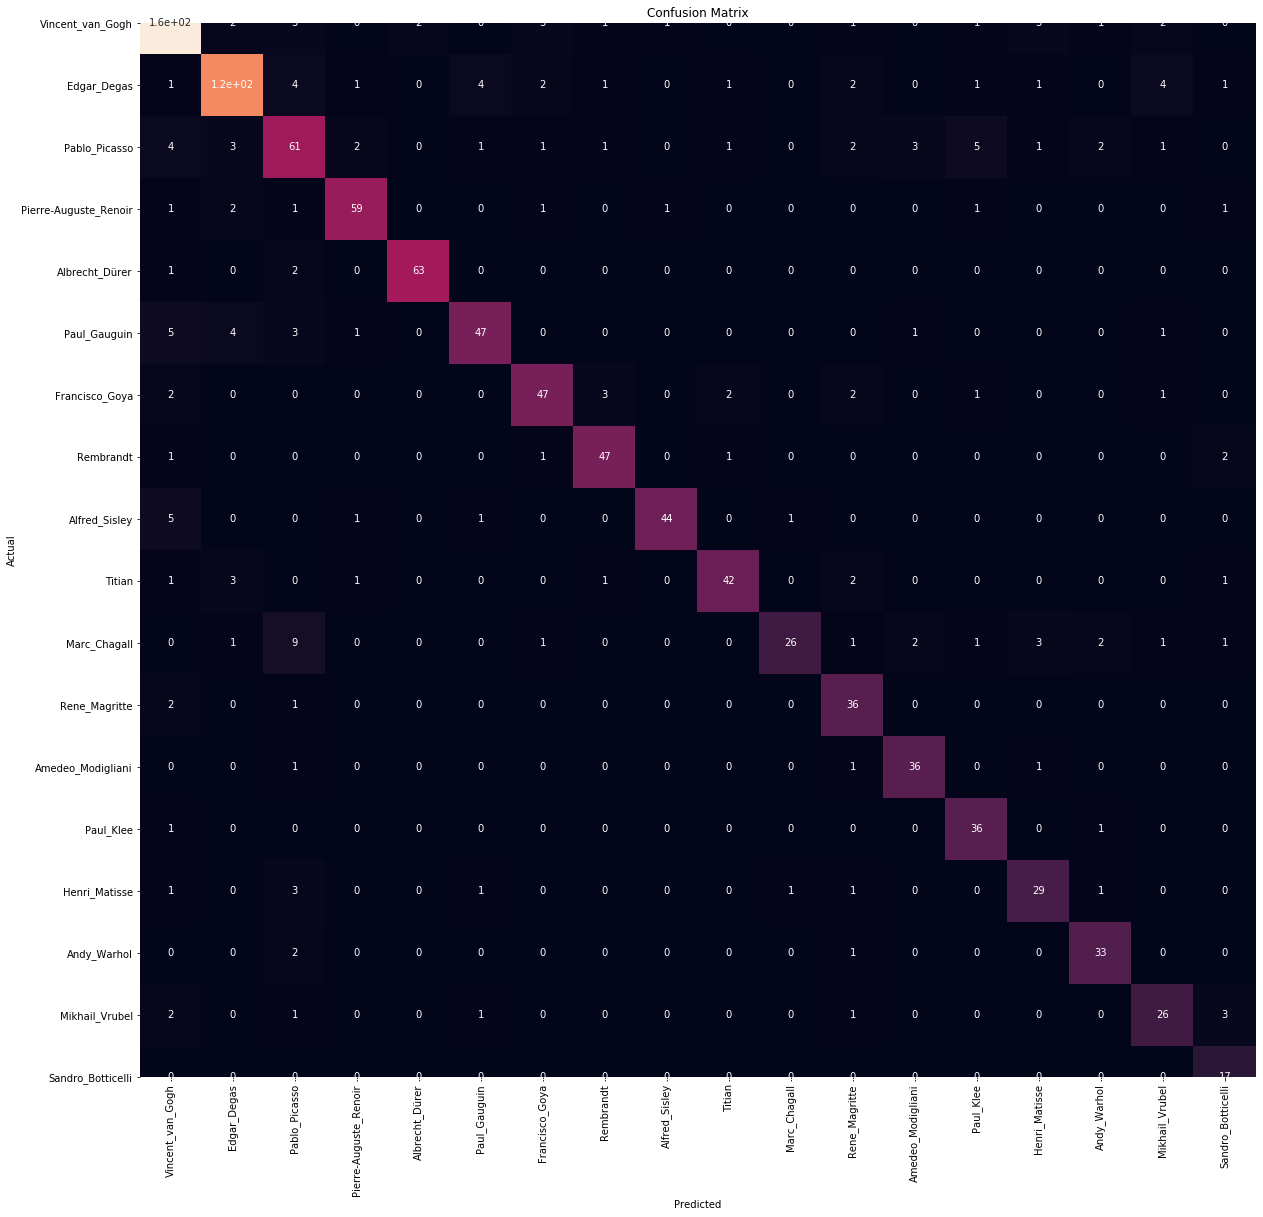

Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.85      0.89      0.87       175
          Edgar_Degas       0.89      0.84      0.86       140
        Pablo_Picasso       0.67      0.69      0.68        88
Pierre-Auguste_Renoir       0.91      0.88      0.89        67
       Albrecht_Dürer       0.97      0.95      0.96        66
         Paul_Gauguin       0.85      0.76      0.80        62
       Francisco_Goya       0.84      0.81      0.82        58
            Rembrandt       0.87      0.90      0.89        52
        Alfred_Sisley       0.96      0.85      0.90        52
               Titian       0.89      0.82      0.86        51
         Marc_Chagall       0.93      0.54      0.68        48
        Rene_Magritte       0.72      0.92      0.81        39
    Amedeo_Modigliani       0.86      0.92      0.89        39
            Paul_Klee       0.78      0.95      0.86        38
        Henri_Matisse       0.7

In [29]:
plot_confusionmatrix(model_Xception, test_generator, STEP_SIZE_TEST)

In [37]:
# Training history of Resnet50-based model and Xception-bsaed model
training_history_Resnet50 = {}
training_history_Resnet50['loss'] = CNN_1.history['loss'] 
training_history_Resnet50['acc'] = CNN_1.history['acc'] 
training_history_Resnet50['val_loss'] = CNN_1.history['val_loss']
training_history_Resnet50['val_acc'] = CNN_1.history['val_acc'] 
training_history_Resnet50['lr'] = CNN_1.history['lr'] 

training_history_Xception = {}
training_history_Xception['loss'] = CNN_Xception.history['loss'][:55]
training_history_Xception['acc'] = CNN_Xception.history['acc'][:55]
training_history_Xception['val_loss'] = CNN_Xception.history['val_loss'][:55]
training_history_Xception['val_acc'] = CNN_Xception.history['val_acc'][:55]
training_history_Xception['lr'] = CNN_Xception.history['lr'][:55]

In [38]:
# Plot the training graph
def plot_training(network, title):
    acc = network['acc']
    val_acc = network['val_acc']
    loss = network['loss']
    val_loss = network['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    fig.suptitle(title)
    plt.show()


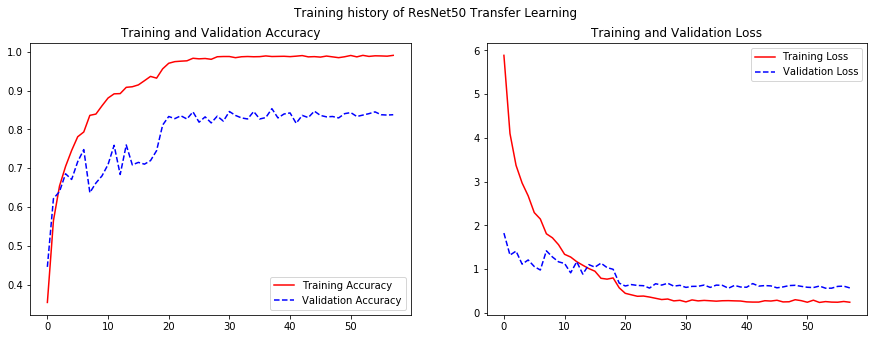

In [39]:
plot_training(training_history_Resnet50, "Training history of ResNet50 Transfer Learning")

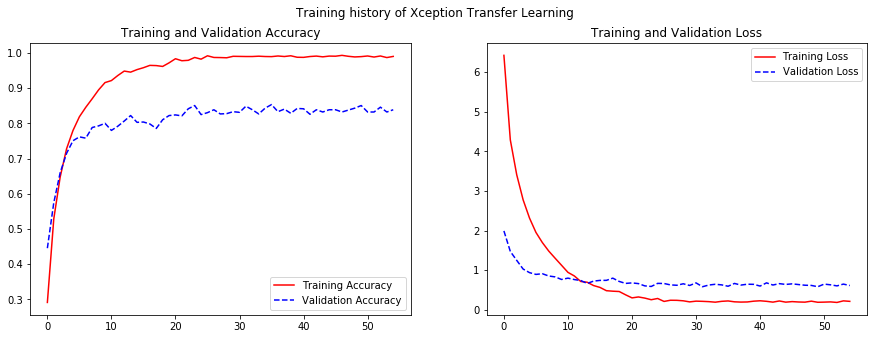

In [40]:
plot_training(training_history_Xception, "Training history of Xception Transfer Learning")

## Reference